Nous importons les différents packages nécéssaires.

In [13]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import math
import time

Initialisation des données : 

In [14]:
dt = 15*60 
nb_intervalles = 672 #nombres d'intervalles de 15 minutes sur 7 jours
temperatures_ext = np.load("Temperatures-Montreal.npy") # donées des températures à Montreal

eta = 0.99 # coefficient relatif à l'isolation
capacite_calorifique = 2.5 #kWh pour chauffer de 1°c le batiment qui fait 360 m³

T_min = 19 #Température minimale du batimenta
T_max = 21 #Température maximale du batiment

cout_elec = np.full(nb_intervalles,0.26) #initalisation du cout de l'élec a 0.26 partout
for i in range(7):
    for j in range(96):
        if j < 28 or j>= 88: #réajustement du cout de l'élec a 0.18 entre 22h et 7h
            cout_elec[j+i*96] = 0.18 
            
COPT_reverse = 3.2 #COPT de la pompe quand on refroidi
def COP_normal(T_ext):
    return 3 + 10 * abs(np.tanh(T_ext/100)) * np.tanh(T_ext/100) #Fonction qui décrit le comportement du COP quand on réchauffe


Tache 1:
La temperature doit rester entre 19°c et 21°c et le modele doit minimiser le coût total de l'électricité consommée par la pompe à chaleur

In [15]:
##Initialisation des variables :

T_int = cp.Variable(nb_intervalles)

#puissance qu'on va utiliser pour la pompe à chaleur
P_chauff = cp.Variable(nb_intervalles, nonneg=True) #en mode normal
P_refroid = cp.Variable(nb_intervalles, nonneg=True) #en mode inverse

## Initialisation du tableau de contraintes pour le probleme qui commence à 0:
contraintes_1 = []

contraintes_1 += [T_int[0] == 20] # Cf énoncé
contraintes_1 += [T_int[-1] == 20] # Cf énoncé
contraintes_1 += [T_int[0] >= 19]
contraintes_1 += [T_int[0] <= 21]

#la température du batiment doit rester admissible: 
contraintes_1 += [T_min <= T_int[i] for i in range(nb_intervalles)]
contraintes_1 += [T_int[i] <= T_max for i in range(nb_intervalles)]

for i in range(nb_intervalles - 1):
    contraintes_1 += [T_int[i+1] - T_int[i] == - (1 - eta) * ( T_int[i]- temperatures_ext[i]) + #perte de temp sans action
                        (COP_normal(temperatures_ext[i]) * P_chauff[i] * dt / (60 *capacite_calorifique)) - #augmentation de la temp en mode normal
                        (COPT_reverse * P_refroid[i] * dt / (60*capacite_calorifique))] #diminution de la temp en mode reverse
    

#Contrainte sur la positivité des puissances et max kW
contraintes_1 += [P_chauff >= 0]
contraintes_1 += [P_refroid >= 0]
contraintes_1 += [P_chauff <= 1]
contraintes_1 += [P_refroid <= 1]

## Initialisation du tableau de contraintes pour le probleme qui commence à 672:
contraintes_2 = []

contraintes_2 += [T_int[0] == 20] # Cf énoncé
contraintes_2 += [T_int[-1] == 20] # Cf énoncé
contraintes_2 += [T_int[0] >= 19]
contraintes_2 += [T_int[0] <= 21]

#la température du batiment doit rester admissible: 
contraintes_2 += [T_min <= T_int[i] for i in range(nb_intervalles)]
contraintes_2 += [T_int[i] <= T_max for i in range(nb_intervalles)]

for i in range(nb_intervalles - 1):
    contraintes_2 += [T_int[i+1] - T_int[i] == - (1 - eta) * ( T_int[i]- temperatures_ext[i+13400]) + #perte de temp sans action
                        (COP_normal(temperatures_ext[i+13400]) * P_chauff[i] * dt / (60 *capacite_calorifique)) - #augmentation de la temp en mode normal
                        (COPT_reverse * P_refroid[i] * dt / (60*capacite_calorifique))] #diminution de la temp en mode reverse

#Contrainte sur la positivité des puissances et max kW
contraintes_2 += [P_chauff >= 0]
contraintes_2 += [P_refroid >= 0]
contraintes_2 += [P_chauff <= 1]
contraintes_2 += [P_refroid <= 1]

## Initialisation du cout total :
cost = cp.sum(cout_elec * (P_chauff + P_refroid)*4) 


/home/iss25/.local/lib/python3.10/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)


Résolution et plot pour tache 1:

1: 
 Puissances normales =  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.17082685e-03 1.10300159e-02 1.10300159e-02 1.10300159e-02
 1.10810413e-02 1.10810413e-02 1.10810413e-02 1.10810413e-02
 1.11611089e-02 1.11611089e-02 1.11611089e-02 1.11611089e-02
 1.15737473e-02 1.15737473e-02 1.15737473e-02 1.15737473e-02
 1.17062404e-02 1.17062404e-02 1.17062404e-02 1.17062404e-02
 1.14031099e-02 1.14031099e-02 1.14031099e-02 1.22598721e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.76341395e-03 1.16568903e-02 1.16568903e-02
 1.18657255e-02 1.18657255e-02 1.18657255e-02 1.18657255e-02
 1.20328662e-02 1.20328662e-02 1.20328662e-02 1.20328662e-02
 1.24632548e-02 1.24632548e-02 1.24632548e-02 1.24632548e-02
 1.21602238e-02 1.21602238e-02 1.21602238e-02 1.21602238e-02
 1.15566472e-02 1.15566472e-02 1.15566472e-02 1.15566472e-02
 1.12050254e-02 1.12050254e-02 1.12050254e-02 1.12050254e

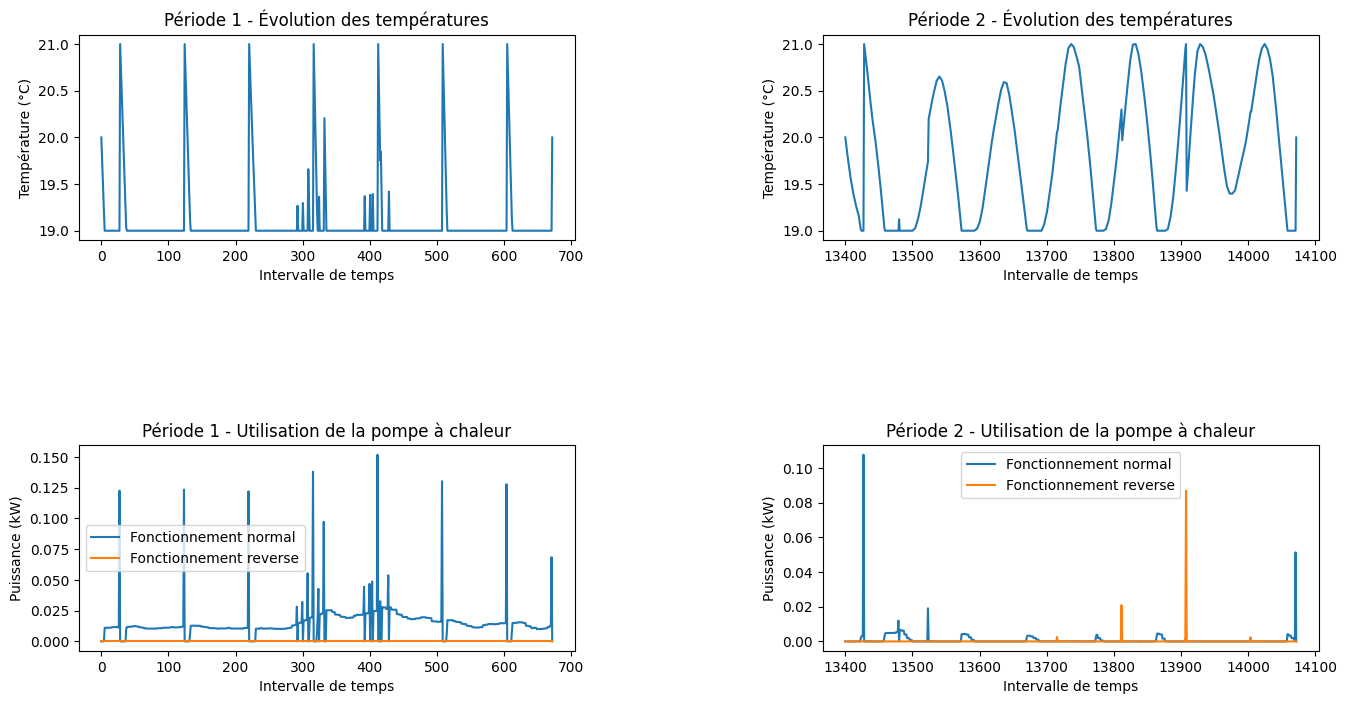

In [16]:
start_time1 = time.time()

##Résolution 1 :
problem1 = cp.Problem(cp.Minimize(cost), contraintes_1)
first =problem1.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
temps_calcul1 = time.time() - start_time1

##Récupération des valeurs :

print("1:", "\n","Puissances normales = ", P_chauff.value, "\n", "Puissances reverses = ", P_refroid.value,"\n", "Températures internes = ", T_int.value, "\n",
      "Cout = ", problem1.value,"\n", "Temps de résolution = ", temps_calcul1)

# Graphique de l'évolution des températures
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
x = np.linspace(0, 672, 672)

axs[0][0].plot(x,T_int.value)
axs[0][0].set_title("Période 1 - Évolution des températures")
axs[0][0].set_xlabel("Intervalle de temps")
axs[0][0].set_ylabel("Température (°C)")

# Graphique représentant l'utilisation de la pompe à chaleur

x = np.linspace(0, 672, 672)

axs[1][0].plot(x, P_chauff.value, label="Fonctionnement normal")
axs[1][0].plot(x, P_refroid.value, label="Fonctionnement reverse")
axs[1][0].set_title("Période 1 - Utilisation de la pompe à chaleur")
axs[1][0].set_xlabel("Intervalle de temps")
axs[1][0].set_ylabel("Puissance (kW)")
axs[1][0].legend()


##Résolution 2 :

start_time2 = time.time()

problem2 = cp.Problem(cp.Minimize(cost), contraintes_2)
second= problem2.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})

temps_calcul2 = time.time() - start_time2

print("Puissances normales = ", P_chauff.value, "\n", "Puissances reverses = ", P_refroid.value,"\n", "Températures internes = ", T_int.value, "\n",
      "Cout = ", problem2.value,"\n", "Temps de résolution = ", temps_calcul2)

# Graphique de l'évolution des températures
x = np.linspace(13400, 13400+672, 672)

axs[0][1].plot(x,T_int.value)
axs[0][1].set_title("Période 2 - Évolution des températures")
axs[0][1].set_xlabel("Intervalle de temps")
axs[0][1].set_ylabel("Température (°C)")

# Graphique représentant l'utilisation de la pompe à chaleur
x = np.linspace(13400, 13400+672, 672)

axs[1][1].plot(x, P_chauff.value, label="Fonctionnement normal")
axs[1][1].plot(x, P_refroid.value, label="Fonctionnement reverse")
axs[1][1].set_title("Période 2 - Utilisation de la pompe à chaleur")
axs[1][1].set_xlabel("Intervalle de temps")
axs[1][1].set_ylabel("Puissance (kW)")
axs[1][1].legend()

#Ajustement des graphs
plt.subplots_adjust(wspace=0.5, hspace= 1)

Tache 2: minimiser l'inconfort total en respectant contrainte de budget

In [17]:
penalite_inf = 3  # pénalité pour chaque degré en dessous de T_min
penalite_sup = 1  # pénalité pour chaque degré au-dessus de T_max

budget_maximal_1 = 8 #par exemple
budget_maximal_2 = 0.4 #par exemple

##Initialisation des variables :

T_int = cp.Variable(nb_intervalles)

#puissance qu'on va utiliser pour la pompe à chaleur
P_chauff = cp.Variable(nb_intervalles, nonneg=True) #en mode normal
P_refroid = cp.Variable(nb_intervalles, nonneg=True) #en mode inverse


inconfort_inf = cp.Variable(nb_intervalles, nonneg=True)  # inconfort pour les températures inférieures à T_min
inconfort_sup = cp.Variable(nb_intervalles, nonneg=True)  # inconfort pour les températures supérieures à T_max


## Initialisation du tableau de contraintes pour le probleme qui commence à 0:
contraintes_1 = []

contraintes_1 += [T_int[0] == 20] # Cf énoncé
contraintes_1 += [T_int[-1] == 20] # Cf énoncé
contraintes_1 += [T_int[0] >= 19]
contraintes_1 += [T_int[0] <= 21]


for i in range(nb_intervalles):
    contraintes_1.append(T_int[i] - T_min >= -inconfort_inf[i]) #l'inconfort correspondant à la différence avec la limite inferieure est stocké dans la variable inconfort_inf[i].
    contraintes_1.append(T_int[i] - T_max <= inconfort_sup[i]) #l'inconfort correspondant à la différence avec la limite supérieure est stocké dans la variable inconfort_inf[i].

for i in range(nb_intervalles - 1):
    contraintes_1 += [T_int[i+1] - T_int[i] == - (1 - eta) * ( T_int[i]- temperatures_ext[i]) + #perte de temp sans action
                        (COP_normal(temperatures_ext[i]) * P_chauff[i] * dt / (60 *capacite_calorifique)) - #augmentation de la temp en mode normal
                        (COPT_reverse * P_refroid[i] * dt / (60*capacite_calorifique))] #diminution de la temp en mode reverse
    
    
#Contrainte sur la positivité des puissances
contraintes_1 += [P_chauff >= 0, P_refroid >= 0]
contraintes_1 += [P_chauff <=  1, P_refroid <= 1]

cost = cp.sum(cout_elec * (P_chauff + P_refroid)*4)

#Contrainte sur le budget
contraintes_1.append(cost <= budget_maximal_1) 

## Initialisation du tableau de contraintes pour le probleme qui commence à 0:
contraintes_2 = []

contraintes_2 += [T_int[0] == 20] # Cf énoncé
contraintes_2 += [T_int[-1] == 20] # Cf énoncé
contraintes_2 += [T_int[0] >= 19]
contraintes_2 += [T_int[0] <= 21]


for i in range(nb_intervalles):
    contraintes_2.append(T_int[i] - T_min >= -inconfort_inf[i]) #l'inconfort correspondant à la différence avec la limite inferieure est stocké dans la variable inconfort_inf[i].
    contraintes_2.append(T_int[i] - T_max <= inconfort_sup[i]) #l'inconfort correspondant à la différence avec la limite supérieure est stocké dans la variable inconfort_inf[i].

for i in range(nb_intervalles - 1):
    contraintes_2 += [T_int[i+1] - T_int[i] == - (1 - eta) * ( T_int[i]- temperatures_ext[i+13400]) + #perte de temp sans action
                        (COP_normal(temperatures_ext[i+13400]) * P_chauff[i] * dt / (60 *capacite_calorifique)) - #augmentation de la temp en mode normal
                        (COPT_reverse * P_refroid[i] * dt / (60*capacite_calorifique))] #diminution de la temp en mode reverse
    
    
#Contrainte sur la positivité des puissances
contraintes_2 += [P_chauff >= 0, P_refroid >= 0]
contraintes_2 += [P_chauff <=  1, P_refroid <= 1]

## Initialisation du cout total et de l'inconfort :

cost = cp.sum(cout_elec * (P_chauff + P_refroid)*4)
total_inconfort = cp.sum(penalite_inf * inconfort_inf + penalite_sup * inconfort_sup) 

#Contrainte sur le budget
contraintes_2.append(cost <= budget_maximal_2) 



/home/iss25/.local/lib/python3.10/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)
/home/iss25/.local/lib/python3.10/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.

  warnings.warn(msg, UserWarning)


Résolution et plot pour tache 2:

1: 
 Puissances normales =  [0.         0.         0.         0.         0.00117083 0.01103002
 0.01103002 0.01103002 0.01108104 0.01108104 0.01108104 0.01108104
 0.01116111 0.01116111 0.01116111 0.01116111 0.01157375 0.01157375
 0.01157375 0.01157375 0.01170624 0.01170624 0.01170624 0.01170624
 0.01140311 0.01140311 0.01140311 0.29976943 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00270313 0.01246325 0.01246325 0.01216022 0.01216022
 0.01216022 0.01216022 0.01155665 0.01155665 0.01155665 0.01155665
 0.01120503 0.01120503 0.01120503 0.01120503 0.01061115 0.01061115
 0.01061115 0.01061115 0.010383   0.010383   0.010383   0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.17358299 0.01075386
 0.01075386 0.01075386 

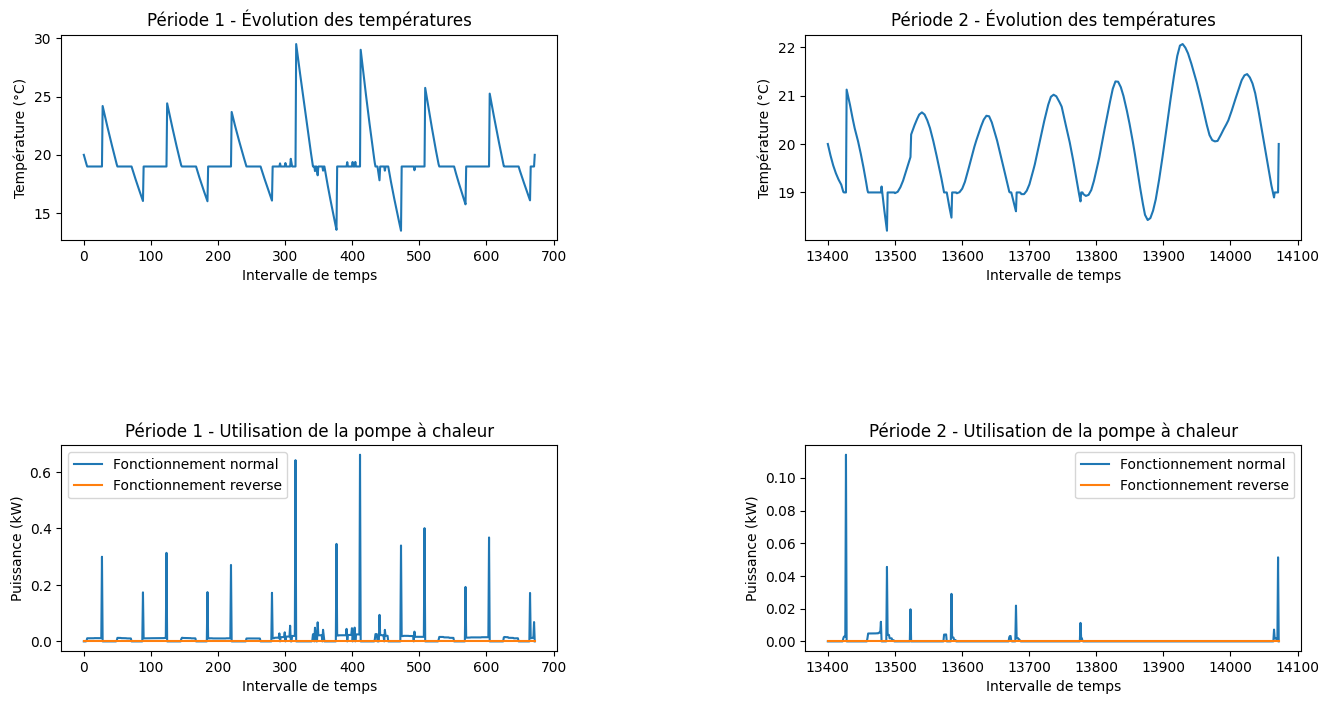

In [18]:

start_time1 = time.time()

##Résolution 1 :
problem1 = cp.Problem(cp.Minimize(total_inconfort), contraintes_1)
first =problem1.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
temps_calcul1 = time.time() - start_time1

##Récupération des valeurs :

print("1:", "\n","Puissances normales = ", P_chauff.value, "\n", "Puissances reverses = ", P_refroid.value,"\n", "Températures internes = ", T_int.value, "\n",
      "Inconfort = ", problem1.value,"\n", "Temps de résolution = ", temps_calcul1)


# Graphique de l'évolution des températures
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
x = np.linspace(0, 672, 672)

axs[0][0].plot(x,T_int.value)
axs[0][0].set_title("Période 1 - Évolution des températures")
axs[0][0].set_xlabel("Intervalle de temps")
axs[0][0].set_ylabel("Température (°C)")



# Graphique représentant l'utilisation de la pompe à chaleur

x = np.linspace(0, 672, 672)

axs[1][0].plot(x, P_chauff.value, label="Fonctionnement normal")
axs[1][0].plot(x, P_refroid.value, label="Fonctionnement reverse")
axs[1][0].set_title("Période 1 - Utilisation de la pompe à chaleur")
axs[1][0].set_xlabel("Intervalle de temps")
axs[1][0].set_ylabel("Puissance (kW)")
axs[1][0].legend()

##Résolution 2 :
start_time2 = time.time()

problem2 = cp.Problem(cp.Minimize(total_inconfort), contraintes_2)
second =problem2.solve()

temps_calcul2 = time.time() - start_time2

##Récupération des valeurs :

print("2:", "\n","Puissances normales = ", P_chauff.value, "\n", "Puissances reverses = ", P_refroid.value,"\n", "Températures internes = ", T_int.value, "\n",
      "Cout = ", cost.value,"\n","Inconfort total = ", problem2.value ,"\n", "Temps de résolution = ", temps_calcul2)



# Graphique de l'évolution des températures
x = np.linspace(13400, 13400+672, 672)

axs[0][1].plot(x,T_int.value)
axs[0][1].set_title("Période 2 - Évolution des températures")
axs[0][1].set_xlabel("Intervalle de temps")
axs[0][1].set_ylabel("Température (°C)")



# Graphique représentant l'utilisation de la pompe à chaleur
x = np.linspace(13400, 13400+672, 672)

axs[1][1].plot(x, P_chauff.value, label="Fonctionnement normal")
axs[1][1].plot(x, P_refroid.value, label="Fonctionnement reverse")
axs[1][1].set_title("Période 2 - Utilisation de la pompe à chaleur")
axs[1][1].set_xlabel("Intervalle de temps")
axs[1][1].set_ylabel("Puissance (kW)")
axs[1][1].legend()

#Ajustement des graphs
plt.subplots_adjust(wspace=0.5, hspace= 1)


Tache 3: graphique représentant au mieux cette relation entre budget et inconfort

Plot pour tache 3: